# Movie Recommendation System

## Data Diri
Nama Lengkap: Kresna Devara

## Import Library

In [1]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 15.1 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633997 sha256=e2e190f275779c9d59049b63d2b096c7355141408c4dd210ef4a17d48fba2487
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from collections import Counter
from math import sqrt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

%matplotlib inline

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Import Data

In [4]:
# download data
!gdown 1Y3YDqlOmM9QywgHBF3hm0-GFytDep4w_

Downloading...
From: https://drive.google.com/uc?id=1Y3YDqlOmM9QywgHBF3hm0-GFytDep4w_
To: /content/MoviesDataset.zip
100% 994k/994k [00:00<00:00, 135MB/s]


In [5]:
!unzip "MoviesDataset.zip" -d MoviesDataset

Archive:  MoviesDataset.zip
  inflating: MoviesDataset/README.txt  
  inflating: MoviesDataset/links.csv  
  inflating: MoviesDataset/movies.csv  
  inflating: MoviesDataset/ratings.csv  
  inflating: MoviesDataset/tags.csv  


In [6]:
df_movies = pd.read_csv('MoviesDataset/movies.csv')
df_movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [7]:
df_ratings = pd.read_csv('MoviesDataset/ratings.csv')
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Exploratory Data Analysis

### Deskripsi dan Check Data

**Penjelasan Data**
***
- MovieId: Unique id dari film
- title: Judul dari film
- Genre: Tipe genre dari film
- UserId: Unique id dari user
- rating: Penilaian film dari user
- timestamp: waktu melakukan submit survey


**Data Check**
***

In [8]:
# movies dataframe
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [9]:
df_movies.nunique()

movieId    9742
title      9737
genres      951
dtype: int64

In [10]:
# ratings dataframe
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
df_ratings.nunique()

userId         610
movieId       9724
rating          10
timestamp    85043
dtype: int64

In [12]:
print("Total Null movies dataframe: " + str(df_movies.isnull().sum().sum()))
print("Total NA movies dataframe: " + str(df_movies.isna().sum().sum()))

print("Total Null ratings dataframe: " + str(df_ratings.isnull().sum().sum()))
print("Total NA ratings dataframe: " + str(df_ratings.isna().sum().sum()))

Total Null movies dataframe: 0
Total NA movies dataframe: 0
Total Null ratings dataframe: 0
Total NA ratings dataframe: 0


Tidak ada data yang kosong

### Univariate Analysis

#### Kolom Genre

Pada kolom genre, jenis genre bukanlah hanya 1 saja, tertapi mutli genre, sehingga untuk mengetahui total jenis genre perlu dilakukan processing terlebih dahulu.

In [13]:
categories = list()
genres = [p.split("|") for p in df_movies.genres.values] 
for c in genres:
  categories += c

In [14]:
pd_genre = pd.DataFrame(Counter(categories).items(), columns=['Category', 'Total'])
pd_genre

,Category,Total
0,Adventure,1263
1,Animation,611
2,Children,664
3,Comedy,3756
4,Fantasy,779
5,Romance,1596
6,Drama,4361
7,Action,1828
8,Crime,1199
9,Thriller,1894


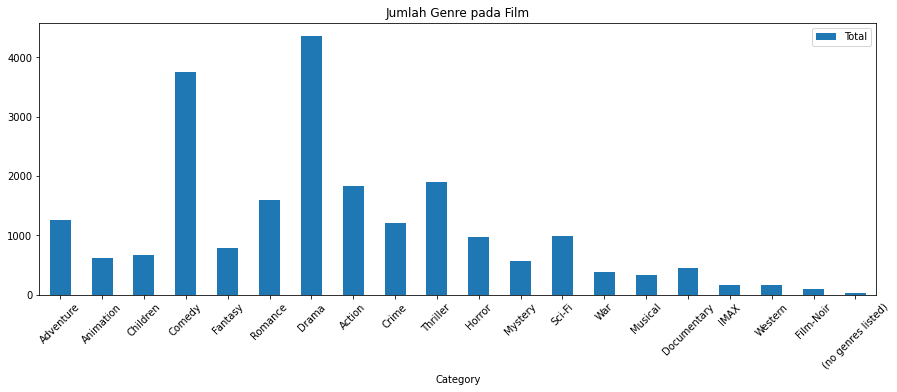

In [15]:
pd_genre.plot.bar(x='Category', y='Total', title='Jumlah Genre pada Film', figsize=(15,5), rot=45)

__Analisa Univariate analyis Genre__
***
1. Film dengan Genre dan Comedy memiliki jumlah dua terbanyak.
2. Terdapat film yang genrenya tidak dijelaskanya **(no genres listed)**

Selanjutnya film dengan genre yang tidak dijelaskan akan dihapus (didrop)

#### Analisa Kolom Rating

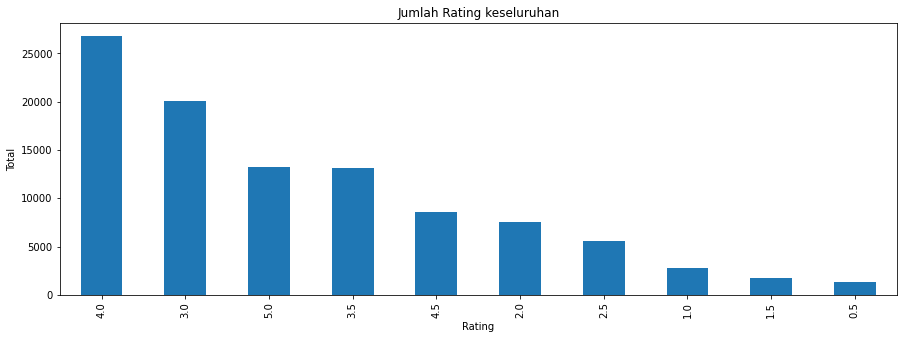

In [16]:
df_ratings['rating'].value_counts().plot.bar(xlabel='Rating', ylabel='Total', title='Jumlah Rating keseluruhan', figsize=(15,5))

__Analisa Univariate analyis kolom Rating__
***
1. Diketahui bahwa user paling banyak memilih rating 4.0.
2. Rating 0.5 memiliki jumlah paling sedikit.

## Data Preparation

Diketahui dari proses sebelumnya bahwa, tidak ada data yang kosong (Null/NA). Namun terdapat film yang memiliki Genre **(not listed)** sehingga film dengan genre tersebut akan didrop. Selanjutnya kita juga akan melakukan pengecekan duplikasi. 

In [17]:
df_movies[df_movies.duplicated()]

,movieId,title,genres


In [18]:
df_ratings[df_ratings.duplicated()]

,userId,movieId,rating,timestamp


Baik dari movies dan juga use rating tidak ada duplikasi. Sehingga data yang didrop hanyalah pada bagian genre yang tidak terdaftar pada dataframe movies dan juga timestamp pada dataframe rating (karena tidak diggunakan)

In [19]:
df_movies = df_movies[df_movies['genres'] != '(no genres listed)']
df_movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [20]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9708 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9708 non-null   int64 
 1   title    9708 non-null   object
 2   genres   9708 non-null   object
dtypes: int64(1), object(2)
memory usage: 303.4+ KB


In [21]:
df_ratings.drop('timestamp', axis=1, inplace=True)
df_ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Untuk melakukan collaborative filtering, data frame ratings akan digabungkan dengan dataframe movies

In [22]:
df_combine = pd.merge(df_ratings, df_movies, on='movieId', how='left')
# df_combine.drop(['title', 'genres'], axis=1, inplace=True)
df_combine

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
100831,610,166534,4.0,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,Get Out (2017),Horror
100834,610,168252,5.0,Logan (2017),Action|Sci-Fi


## Modeling

### Content Based Filtering

Pada Content Based Filtering kita hanya akan menggunakan Dataframe movies

In [23]:
# make bank of token
bow = CountVectorizer(stop_words="english", tokenizer=word_tokenize)
bank = bow.fit_transform(df_movies.genres)

#### Step 1: Encode 

In [24]:
idx = 0
content = df_movies.loc[idx, 'genres']
content

'Adventure|Animation|Children|Comedy|Fantasy'

In [25]:
code = bow.transform([content])
code

<1x950 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Row format>

#### Step 2: Document Search

In [26]:
dist = cosine_distances(code, bank)
dist

array([[0., 1., 1., ..., 1., 1., 1.]])

In [27]:
rec_idx = dist.argsort()[0, 1:11]
rec_idx

array([2809, 2355, 3568, 1706, 3000, 8219, 6194, 7760, 8921, 6948])

#### Step 3: Rekomendasi

In [28]:
df_movies.loc[rec_idx]

,movieId,title,genres
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8921,135815,The Magnificent Ruffians (1979),Action|Drama
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy


#### Membuat Class

In [29]:
class ContentRecommender:
  """
  df: dataframe 
  content_col: nama kolom yang akan dianalisa
  """
  def __init__(self, dataframe, content_col):
    self.df = dataframe
    self.content_col = content_col
    self.encoder = None
    self.bank = None
      
  def fit(self):
    self.encoder = CountVectorizer(stop_words="english", tokenizer=word_tokenize)
    self.bank = self.encoder.fit_transform(self.df[self.content_col])

  def recommend(self, idx, topk=10):
    """
    idx: Nomor index input
    topk: Nomor rekomendasi yang diinginkan
    """
    content = self.df.loc[idx, self.content_col]
    code = self.encoder.transform([content])
    dist = cosine_distances(code, self.bank)
    rec_idx = dist.argsort()[0,1:(topk+1)]
    return self.df.loc[rec_idx]

In [30]:
contentrec = ContentRecommender(df_movies, 'genres')
contentrec.fit()

In [31]:
contentrec.recommend(1, topk=10)

,movieId,title,genres
6751,59501,"Chronicles of Narnia: Prince Caspian, The (2008)",Adventure|Children|Fantasy
1617,2161,"NeverEnding Story, The (1984)",Adventure|Children|Fantasy
3574,4896,Harry Potter and the Sorcerer's Stone (a.k.a. ...,Adventure|Children|Fantasy
1618,2162,"NeverEnding Story II: The Next Chapter, The (1...",Adventure|Children|Fantasy
109,126,"NeverEnding Story III, The (1994)",Adventure|Children|Fantasy
53,60,"Indian in the Cupboard, The (1995)",Adventure|Children|Fantasy
8230,104074,Percy Jackson: Sea of Monsters (2013),Adventure|Children|Fantasy
7478,82169,Chronicles of Narnia: The Voyage of the Dawn T...,Adventure|Children|Fantasy
9319,159849,Bo Burnham: Make Happy (2016),Comedy
6629,56171,"Golden Compass, The (2007)",Adventure|Children|Fantasy


film dengan index 2 adalah Jumanji (1995)	dengan Adventure|Children|Fantasy, dari 10 rekomendasi yang diberikan. terdapat 9 film dengan genre yang sama persis. Hanya 1 film saja yang memiliki genre yang berbeda.

### Collaborative Filtering

Collaborative Filtering kali ini akan menggunakan model SVD

In [32]:
df_combine_new = df_combine.copy()
df_combine_new.drop(['title', 'genres'], axis=1, inplace=True)

In [33]:
data = Dataset.load_from_df(df_combine_new, Reader(rating_scale=(0, 5)))

In [34]:
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

In [35]:
model = SVD(random_state=42)
model.fit(trainset)

#### Melakukan prediksi Film yang Belum diTonton

In [36]:
user_id = 1
watched = df_combine[df_combine.userId == user_id].movieId

In [37]:
all_moviesId = df_combine.movieId.unique()

In [38]:
not_watched = [movieId for movieId in all_moviesId if movieId not in watched]

In [39]:
score = [model.predict(user_id, movie).est for movie in not_watched]
score[:10]

[4.421072694046775,
 4.976504660233453,
 4.920347381016457,
 3.9827487546741716,
 4.371582315160077,
 4.330351026998051,
 4.895606311703691,
 4.499620535412294,
 3.7374912391054935,
 3.9014347090366224]

#### Membuat class

In [40]:
class CollaborativeRecommender:
  def __init__(self, data):
    self.df_full = data.copy()
    self.df_process = data.copy()
    self.df_process.drop(['title', 'genres'], axis=1, inplace=True)

    self.all_movies =  self.df_process.movieId.unique()
    self.model = None

  def fit(self):
    data = Dataset.load_from_df(self.df_process, Reader())
    trainset = data.build_full_trainset()
    
    self.model = SVD(random_state=42)
    self.model.fit(trainset)
           
  def recommend(self, user_id, topk=10):
    watched = self.df_process[self.df_process.userId == user_id].movieId
    not_watched = [movie for movie in self.all_movies if movie not in watched]
    score = [self.model.predict(user_id, movie).est for movie in not_watched]
    title = [self.df_full[self.df_full['movieId'] == n].title.unique()[0] for n in not_watched]
    genres = [self.df_full[self.df_full['movieId'] == n].genres.unique()[0] for n in not_watched]
    
    result = pd.DataFrame({"movieId": not_watched, "title": title, "genres": genres, "pred_score":score})
    result.sort_values("pred_score", ascending=False, inplace=True)
    return result.head(topk)

In [41]:
collrecs = CollaborativeRecommender(df_combine)

In [42]:
collrecs.fit()

In [43]:
collrecs.recommend(0, topk=10)

,movieId,title,genres,pred_score
232,318,"Shawshank Redemption, The (1994)",Crime|Drama,4.391453
2395,1204,Lawrence of Arabia (1962),Adventure|Drama|War,4.372247
722,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War,4.316383
1027,858,"Godfather, The (1972)",Crime|Drama,4.259852
1110,1276,Cool Hand Luke (1967),Drama,4.248498
1184,3275,"Boondock Saints, The (2000)",Action|Crime|Drama|Thriller,4.244425
332,904,Rear Window (1954),Mystery|Thriller,4.241529
74,1213,Goodfellas (1990),Crime|Drama,4.240992
192,2959,Fight Club (1999),Action|Crime|Drama|Thriller,4.240525
2158,3451,Guess Who's Coming to Dinner (1967),Drama,4.240311


## Metrik Evaluasi

### Content Based Filtering

Evaluasi yang digunakan pada Content Based Filtering adalah Precission dimana: \
`P = Jumlah rekomendasi yang relevan/Jumlah rekomendasi`

kita akan melakukan rekomendasi sebanyak 30 dan akan melihat jumlah yang relevan


In [44]:
contentrec.recommend(0, topk=30)

,movieId,title,genres
2809,3754,"Adventures of Rocky and Bullwinkle, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
2355,3114,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
3568,4886,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
1706,2294,Antz (1998),Adventure|Animation|Children|Comedy|Fantasy
3000,4016,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy
8219,103755,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
6194,45074,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
7760,91355,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
8921,135815,The Magnificent Ruffians (1979),Action|Drama
6948,65577,"Tale of Despereaux, The (2008)",Adventure|Animation|Children|Comedy|Fantasy


Pada contoh di diatas dari 30 film yang direkomendasikan ada 25 film yang relevan, dan 5 yang tidak sehingga Precisionnya <br>
`P = 25/30 = 0.83`

### Collaborative Filtering

Pada Collaborative Filtering, Rating Prediki akan dibandingan dengan Rating aslinya dengan menggunakan Root Mean Square Error dari model pada sesi sebelumnya

In [45]:
test_result = model.test(testset)
df_test = pd.DataFrame(test_result)
df_test.drop('details', axis=1, inplace=True)
df_test.columns = ['userId', 'movieId', 'Rating_actual', 'Rating_predictions']

In [46]:
df_test.head()

,userId,movieId,Rating_actual,Rating_predictions
0,217,1287,3.0,2.904351
1,594,7032,4.0,3.960984
2,117,697,3.0,3.205882
3,610,43928,2.0,3.111869
4,414,3986,1.5,2.906399


In [47]:
mae = mean_absolute_error(df_test.Rating_actual, df_test.Rating_predictions)
mse = mean_squared_error(df_test.Rating_actual, df_test.Rating_predictions)
rms = sqrt(mse)
print(f"MAE: {mae}\nMSE: {mse}\nRMS :{rms}")

MAE: 0.6779972544100991
MSE: 0.7746897725805474
RMS :0.880164628112575


## Kesimpulan

Meskipun tidak dapat dibandingan secara langsung (Head to Head) antara Content based filtering dan juga Collaborative Filtering. Namun hasil evaluasi metrik pada keduanya cukup bagus dimana Contant-Based Memiliki Presisi sebesar 0.83 dan RMS 0.88 pada Collaborative Filtering